# 算子学习简要教程 - 纯PyTorch实现 🚀

## 欢迎来到算子学习的世界！

本教程将带您从零开始理解和实现算子学习，使用纯PyTorch构建Deep Operator Networks (DeepONet)。

### 🎯 学习目标
- 理解算子学习的基本概念
- 掌握DeepONet的数学原理
- 使用PyTorch从零实现DeepONet
- 解决实际的算子学习问题

### 📚 内容大纲
1. **算子学习基础** - 什么是算子学习？
2. **DeepONet架构** - 分支网络与主干网络
3. **PyTorch实现** - 从零构建模型
4. **实际案例** - 反应扩散方程求解
5. **结果分析** - 可视化与误差分析

## 1. 环境准备与导入库 🛠️

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设备选择
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ 使用设备: {device}")
print(f"🔥 PyTorch版本: {torch.__version__}")

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')

print("✅ 环境准备完成！")

🖥️ 使用设备: cpu
🔥 PyTorch版本: 2.8.0
✅ 环境准备完成！


## 2. 算子学习基础概念 📐

### 什么是算子学习？

**传统神经网络**：学习函数映射 $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$

**算子学习**：学习函数到函数的映射 $\mathcal{G}: \mathcal{U} \rightarrow \mathcal{V}$

其中 $\mathcal{U}$ 和 $\mathcal{V}$ 是函数空间。

### DeepONet架构

DeepONet由两个子网络组成：
- **分支网络 (Branch Network)**: 处理输入函数的信息
- **主干网络 (Trunk Network)**: 处理查询位置的坐标

数学表达式：
$$\mathcal{G}(u)(y) = \sum_{k=1}^{p} \text{Branch}_k(u) \cdot \text{Trunk}_k(y) + b$$

其中：
- $u$ 是输入函数
- $y$ 是查询位置
- $p$ 是潜在空间维度
- $b$ 是偏置项

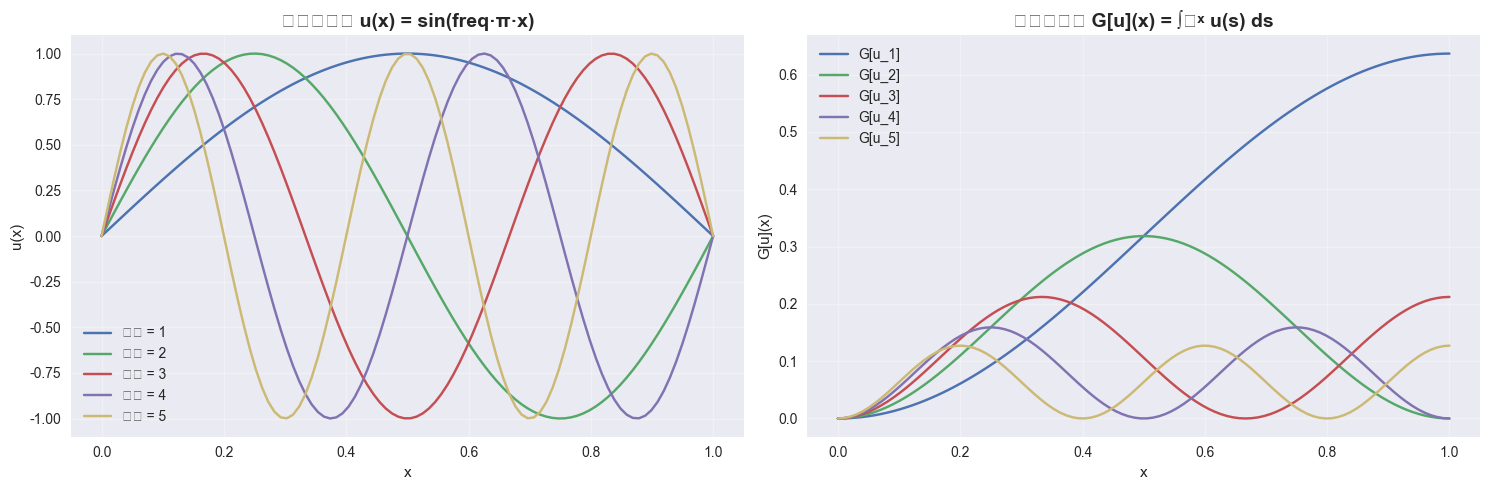

📊 这就是算子学习的目标：
   🎯 学习从输入函数族到输出函数族的映射
   🧠 DeepONet将学习积分算子 G[u](x) = ∫₀ˣ u(s) ds
   🔄 给定任意新的输入函数，网络能预测对应的输出函数


In [2]:
# 演示算子学习的概念
def demonstrate_operator_concept():
    """演示算子学习的基本概念"""
    
    # 创建示例数据
    x = np.linspace(0, 1, 100)
    
    # 输入函数族：不同频率的正弦函数
    input_functions = []
    output_functions = []
    
    for freq in [1, 2, 3, 4, 5]:
        # 输入函数 u(x) = sin(freq * π * x)
        u = np.sin(freq * np.pi * x)
        input_functions.append(u)
        
        # 输出函数：积分算子的结果
        # G[u](x) = ∫₀ˣ u(s) ds
        G_u = np.array([np.trapz(u[:i+1], x[:i+1]) if i > 0 else 0 for i in range(len(x))])
        output_functions.append(G_u)
    
    # 可视化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 输入函数族
    for i, u in enumerate(input_functions):
        ax1.plot(x, u, label=f'频率 = {i+1}')
    ax1.set_title('输入函数族 u(x) = sin(freq·π·x)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('x')
    ax1.set_ylabel('u(x)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 输出函数族（积分算子的结果）
    for i, G_u in enumerate(output_functions):
        ax2.plot(x, G_u, label=f'G[u_{i+1}]')
    ax2.set_title('输出函数族 G[u](x) = ∫₀ˣ u(s) ds', fontsize=14, fontweight='bold')
    ax2.set_xlabel('x')
    ax2.set_ylabel('G[u](x)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 这就是算子学习的目标：")
    print("   🎯 学习从输入函数族到输出函数族的映射")
    print("   🧠 DeepONet将学习积分算子 G[u](x) = ∫₀ˣ u(s) ds")
    print("   🔄 给定任意新的输入函数，网络能预测对应的输出函数")

demonstrate_operator_concept()

## 3. 使用PyTorch实现DeepONet 🏗️

让我们从零开始构建一个完整的DeepONet模型。

In [3]:
class MLP(nn.Module):
    """多层感知机基础类"""
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation='tanh'):
        super(MLP, self).__init__()
        
        # 选择激活函数
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'swish':
            self.activation = nn.SiLU()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        
        # 构建网络层
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            # 除了最后一层，都添加激活函数
            if i < len(dims) - 2:
                layers.append(self.activation)
        
        self.network = nn.Sequential(*layers)
        
        # 初始化权重
        self.init_weights()
    
    def init_weights(self):
        """Xavier均匀初始化"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.network(x)


class SimpleDeepONet(nn.Module):
    """简化版DeepONet实现"""
    
    def __init__(self, n_sensors, coord_dim, hidden_dim=100, latent_dim=100):
        super(SimpleDeepONet, self).__init__()
        
        self.n_sensors = n_sensors
        self.coord_dim = coord_dim
        self.latent_dim = latent_dim
        
        # 分支网络：处理传感器数据
        self.branch_net = MLP(
            input_dim=n_sensors,
            hidden_dims=[hidden_dim, hidden_dim, hidden_dim],
            output_dim=latent_dim
        )
        
        # 主干网络：处理查询坐标
        self.trunk_net = MLP(
            input_dim=coord_dim,
            hidden_dims=[hidden_dim, hidden_dim, hidden_dim],
            output_dim=latent_dim
        )
        
        # 偏置项
        self.bias = nn.Parameter(torch.zeros(1))
        
        print(f"🏗️ DeepONet模型创建完成:")
        print(f"   📡 传感器数量: {n_sensors}")
        print(f"   📍 坐标维度: {coord_dim}")
        print(f"   🧠 潜在空间维度: {latent_dim}")
        print(f"   🔢 总参数数: {sum(p.numel() for p in self.parameters()):,}")
    
    def forward(self, sensor_data, query_coords):
        """
        前向传播
        
        Args:
            sensor_data: 传感器数据 [batch_size, n_sensors]
            query_coords: 查询坐标 [batch_size, n_queries, coord_dim]
        
        Returns:
            output: 预测结果 [batch_size, n_queries, 1]
        """
        batch_size = sensor_data.shape[0]
        n_queries = query_coords.shape[1]
        
        # 分支网络输出: [batch_size, latent_dim]
        branch_output = self.branch_net(sensor_data)
        
        # 主干网络输出: [batch_size * n_queries, latent_dim]
        coords_flat = query_coords.view(-1, self.coord_dim)
        trunk_output = self.trunk_net(coords_flat)
        trunk_output = trunk_output.view(batch_size, n_queries, self.latent_dim)
        
        # 计算内积: [batch_size, n_queries]
        # branch_output: [batch_size, latent_dim]
        # trunk_output: [batch_size, n_queries, latent_dim]
        output = torch.einsum('bl,bql->bq', branch_output, trunk_output)
        
        # 添加偏置并扩展维度: [batch_size, n_queries, 1]
        output = output + self.bias
        output = output.unsqueeze(-1)
        
        return output

# 测试模型创建
model = SimpleDeepONet(n_sensors=50, coord_dim=1, hidden_dim=64, latent_dim=64)

# 测试前向传播
batch_size = 8
n_queries = 100

test_sensor_data = torch.randn(batch_size, 50)
test_query_coords = torch.randn(batch_size, n_queries, 1)

test_output = model(test_sensor_data, test_query_coords)
print(f"\n✅ 前向传播测试成功!")
print(f"   📊 输入形状: 传感器数据{test_sensor_data.shape}, 查询坐标{test_query_coords.shape}")
print(f"   📈 输出形状: {test_output.shape}")

🏗️ DeepONet模型创建完成:
   📡 传感器数量: 50
   📍 坐标维度: 1
   🧠 潜在空间维度: 64
   🔢 总参数数: 28,353

✅ 前向传播测试成功!
   📊 输入形状: 传感器数据torch.Size([8, 50]), 查询坐标torch.Size([8, 100, 1])
   📈 输出形状: torch.Size([8, 100, 1])


## 4. 数据生成：一维积分算子问题 📊

我们来解决一个具体的算子学习问题：学习积分算子。

**问题设定**:
- 输入函数: $u(x) = \sum_{k=1}^{5} a_k \sin(k\pi x)$
- 积分算子: $\mathcal{G}[u](y) = \int_0^y u(x) dx$
- 目标: 学习从 $u$ 到 $\mathcal{G}[u]$ 的映射

📊 创建积分算子数据集:
   📈 样本数量: 800
   📡 传感器数量: 50
   📍 查询点数量: 100
   🔢 定义域: [0, 1]


生成数据: 100%|██████████| 800/800 [00:00<00:00, 14877.05it/s]


✅ 数据生成完成!
   📊 传感器数据形状: torch.Size([800, 50])
   📍 查询坐标形状: torch.Size([800, 100, 1])
   🎯 目标值形状: torch.Size([800, 100, 1])


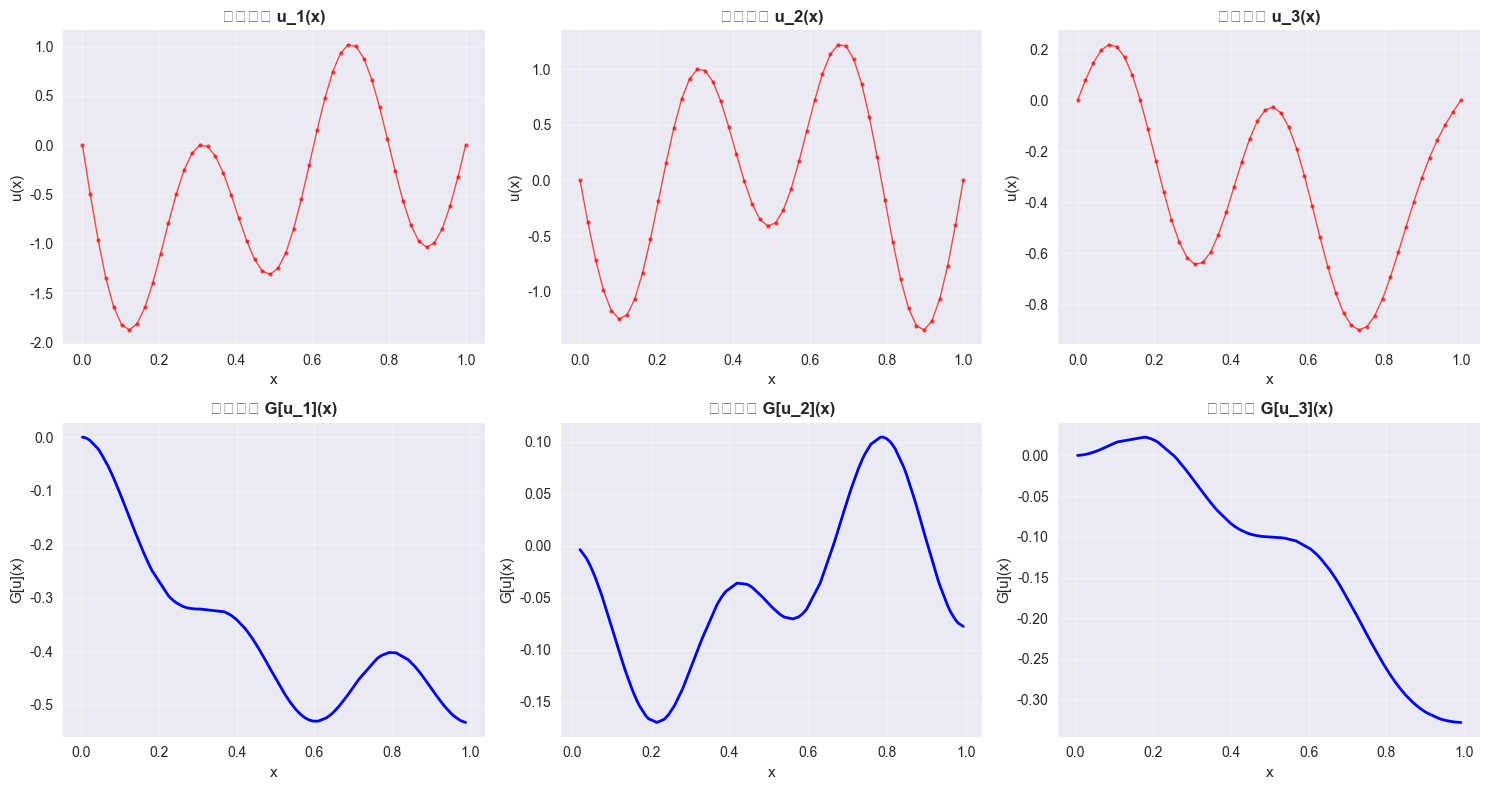

In [4]:
class IntegralOperatorDataset:
    """积分算子数据集"""
    
    def __init__(self, n_samples=1000, n_sensors=50, n_queries=100, domain=[0, 1]):
        self.n_samples = n_samples
        self.n_sensors = n_sensors
        self.n_queries = n_queries
        self.domain = domain
        
        # 传感器位置（固定）
        self.sensor_locations = torch.linspace(domain[0], domain[1], n_sensors)
        
        print(f"📊 创建积分算子数据集:")
        print(f"   📈 样本数量: {n_samples}")
        print(f"   📡 传感器数量: {n_sensors}")
        print(f"   📍 查询点数量: {n_queries}")
        print(f"   🔢 定义域: {domain}")
    
    def generate_input_function(self, coeffs):
        """
        生成输入函数 u(x) = Σ a_k sin(k*π*x)
        
        Args:
            coeffs: 傅里叶系数 [n_modes]
            
        Returns:
            function: 在传感器位置的函数值
        """
        x = self.sensor_locations
        u = torch.zeros_like(x)
        
        for k, a_k in enumerate(coeffs, 1):
            u += a_k * torch.sin(k * np.pi * x)
        
        return u
    
    def compute_integral(self, coeffs, query_points):
        """
        计算积分算子的解析解
        G[u](y) = ∫₀ʸ u(x) dx
        
        For u(x) = Σ a_k sin(k*π*x), the integral is:
        G[u](y) = Σ a_k * (1 - cos(k*π*y)) / (k*π)
        """
        integral_values = torch.zeros_like(query_points)
        
        for k, a_k in enumerate(coeffs, 1):
            integral_values += a_k * (1 - torch.cos(k * np.pi * query_points)) / (k * np.pi)
        
        return integral_values
    
    def generate_data(self):
        """生成训练数据"""
        
        sensor_data = []
        query_coords = []
        target_values = []
        
        for i in tqdm(range(self.n_samples), desc="生成数据"):
            # 随机生成傅里叶系数
            coeffs = torch.randn(5) * 0.5  # 5个模态
            
            # 生成输入函数在传感器位置的值
            u_sensors = self.generate_input_function(coeffs)
            sensor_data.append(u_sensors)
            
            # 随机选择查询点
            query_points = torch.rand(self.n_queries) * (self.domain[1] - self.domain[0]) + self.domain[0]
            query_points = query_points.sort()[0]  # 排序以便可视化
            query_coords.append(query_points.unsqueeze(-1))
            
            # 计算积分算子的精确值
            integral_exact = self.compute_integral(coeffs, query_points)
            target_values.append(integral_exact.unsqueeze(-1))
        
        # 转换为张量
        sensor_data = torch.stack(sensor_data)
        query_coords = torch.stack(query_coords)
        target_values = torch.stack(target_values)
        
        print(f"\n✅ 数据生成完成!")
        print(f"   📊 传感器数据形状: {sensor_data.shape}")
        print(f"   📍 查询坐标形状: {query_coords.shape}")
        print(f"   🎯 目标值形状: {target_values.shape}")
        
        return sensor_data, query_coords, target_values
    
    def visualize_samples(self, sensor_data, query_coords, target_values, n_samples=3):
        """可视化几个样本"""
        
        fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))
        
        for i in range(n_samples):
            # 输入函数
            x_fine = torch.linspace(0, 1, 200)
            axes[0, i].plot(self.sensor_locations, sensor_data[i], 'ro-', markersize=3, linewidth=1, alpha=0.7)
            axes[0, i].set_title(f'输入函数 u_{i+1}(x)', fontweight='bold')
            axes[0, i].set_xlabel('x')
            axes[0, i].set_ylabel('u(x)')
            axes[0, i].grid(True, alpha=0.3)
            
            # 积分算子结果
            query_x = query_coords[i].squeeze()
            target_y = target_values[i].squeeze()
            axes[1, i].plot(query_x, target_y, 'b-', linewidth=2)
            axes[1, i].set_title(f'积分算子 G[u_{i+1}](x)', fontweight='bold')
            axes[1, i].set_xlabel('x')
            axes[1, i].set_ylabel('G[u](x)')
            axes[1, i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# 创建数据集
dataset = IntegralOperatorDataset(n_samples=800, n_sensors=50, n_queries=100)
sensor_data, query_coords, target_values = dataset.generate_data()

# 可视化样本
dataset.visualize_samples(sensor_data, query_coords, target_values)

## 5. 模型训练 🚀

现在让我们训练DeepONet来学习积分算子。

📊 数据分割完成:
   🚂 训练集: 640 样本
   🔍 验证集: 160 样本

🚀 开始训练 3000 轮次...


训练进度:  33%|███▎      | 1001/3000 [01:19<02:36, 12.75it/s]


轮次 1000/3000: 训练损失 = 1.714035e-05, 验证损失 = 2.230288e-05, 学习率 = 6.7e-06


训练进度:  67%|██████▋   | 2001/3000 [02:36<01:17, 12.83it/s]


轮次 2000/3000: 训练损失 = 1.498512e-05, 验证损失 = 1.946151e-05, 学习率 = 4.4e-08


训练进度: 100%|██████████| 3000/3000 [03:54<00:00, 12.79it/s]



轮次 3000/3000: 训练损失 = 1.497176e-05, 验证损失 = 1.944583e-05, 学习率 = 2.9e-10

✅ 训练完成!
   📉 最终训练损失: 1.497176e-05
   📊 最终验证损失: 1.944583e-05


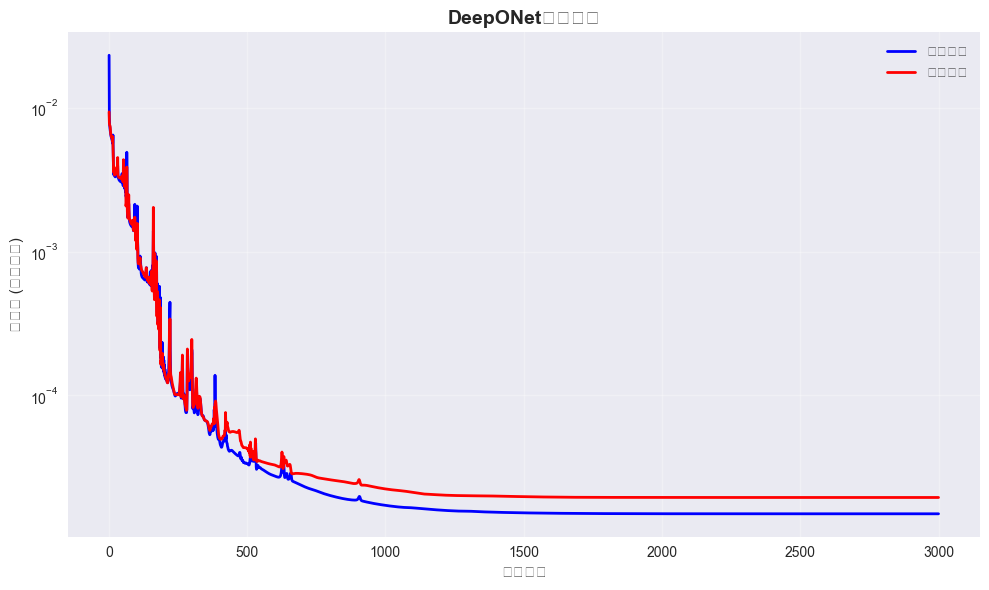

In [5]:
class DeepONetTrainer:
    """DeepONet训练器"""
    
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.history = {'train_loss': [], 'val_loss': []}
    
    def train(self, sensor_data, query_coords, target_values, 
              epochs=5000, batch_size=32, lr=1e-3, val_split=0.2):
        """训练模型"""
        
        # 数据分割
        n_samples = sensor_data.shape[0]
        n_val = int(n_samples * val_split)
        n_train = n_samples - n_val
        
        indices = torch.randperm(n_samples)
        train_idx, val_idx = indices[:n_train], indices[n_train:]
        
        train_sensor = sensor_data[train_idx].to(self.device)
        train_coords = query_coords[train_idx].to(self.device)
        train_targets = target_values[train_idx].to(self.device)
        
        val_sensor = sensor_data[val_idx].to(self.device)
        val_coords = query_coords[val_idx].to(self.device)
        val_targets = target_values[val_idx].to(self.device)
        
        print(f"📊 数据分割完成:")
        print(f"   🚂 训练集: {n_train} 样本")
        print(f"   🔍 验证集: {n_val} 样本")
        
        # 优化器和损失函数
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
        criterion = nn.MSELoss()
        
        print(f"\n🚀 开始训练 {epochs} 轮次...")
        
        # 训练循环
        for epoch in tqdm(range(epochs), desc="训练进度"):
            # 训练阶段
            self.model.train()
            train_loss = 0.0
            
            # 批次训练
            n_batches = (n_train + batch_size - 1) // batch_size
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, n_train)
                
                batch_sensor = train_sensor[start_idx:end_idx]
                batch_coords = train_coords[start_idx:end_idx]
                batch_targets = train_targets[start_idx:end_idx]
                
                optimizer.zero_grad()
                
                # 前向传播
                predictions = self.model(batch_sensor, batch_coords)
                loss = criterion(predictions, batch_targets)
                
                # 反向传播
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            train_loss /= n_batches
            
            # 验证阶段
            self.model.eval()
            with torch.no_grad():
                val_predictions = self.model(val_sensor, val_coords)
                val_loss = criterion(val_predictions, val_targets).item()
            
            # 记录历史
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            
            # 学习率调度
            scheduler.step()
            
            # 打印进度
            if (epoch + 1) % 1000 == 0:
                print(f"\n轮次 {epoch+1:4d}/{epochs}: "
                      f"训练损失 = {train_loss:.6e}, "
                      f"验证损失 = {val_loss:.6e}, "
                      f"学习率 = {optimizer.param_groups[0]['lr']:.1e}")
        
        print(f"\n✅ 训练完成!")
        print(f"   📉 最终训练损失: {self.history['train_loss'][-1]:.6e}")
        print(f"   📊 最终验证损失: {self.history['val_loss'][-1]:.6e}")
        
        return self.history
    
    def plot_training_history(self):
        """绘制训练历史"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        epochs = range(1, len(self.history['train_loss']) + 1)
        ax.semilogy(epochs, self.history['train_loss'], 'b-', linewidth=2, label='训练损失')
        ax.semilogy(epochs, self.history['val_loss'], 'r-', linewidth=2, label='验证损失')
        
        ax.set_xlabel('训练轮次')
        ax.set_ylabel('损失值 (对数尺度)')
        ax.set_title('DeepONet训练历史', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# 创建训练器并训练
trainer = DeepONetTrainer(model, device=device)
history = trainer.train(sensor_data, query_coords, target_values, 
                       epochs=3000, batch_size=16, lr=1e-3)

# 绘制训练历史
trainer.plot_training_history()

## 6. 模型评估与可视化 📊

让我们评估训练好的模型性能，并可视化预测结果。

🧪 生成测试数据...


生成数据: 100%|██████████| 800/800 [00:00<00:00, 14361.17it/s]


✅ 数据生成完成!
   📊 传感器数据形状: torch.Size([800, 50])
   📍 查询坐标形状: torch.Size([800, 100, 1])
   🎯 目标值形状: torch.Size([800, 100, 1])

📊 模型性能评估:
   📈 均方误差 (MSE): 1.827134e-05
   📏 平均绝对误差 (MAE): 3.078624e-03
   📋 相对误差: 61.438736


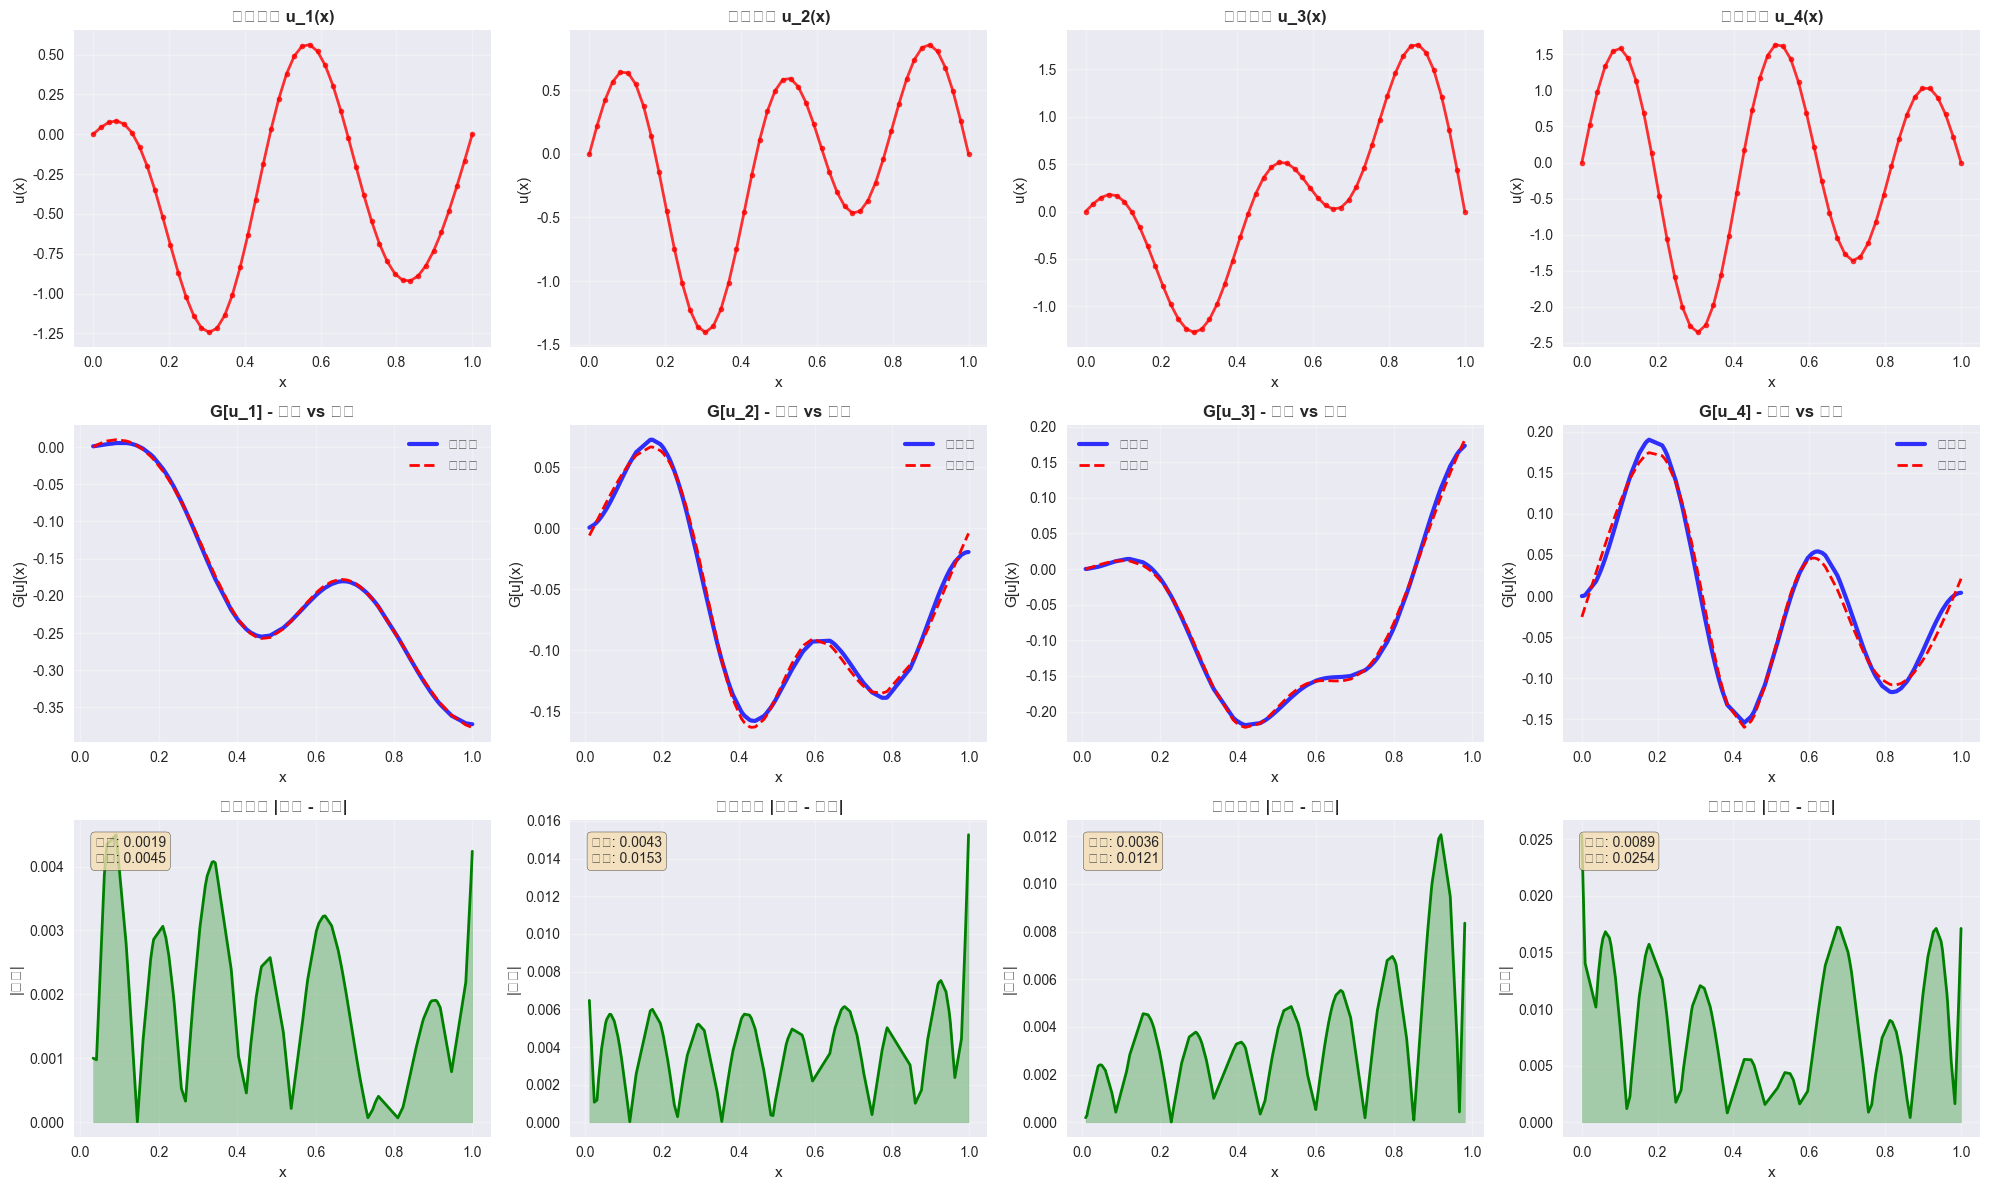

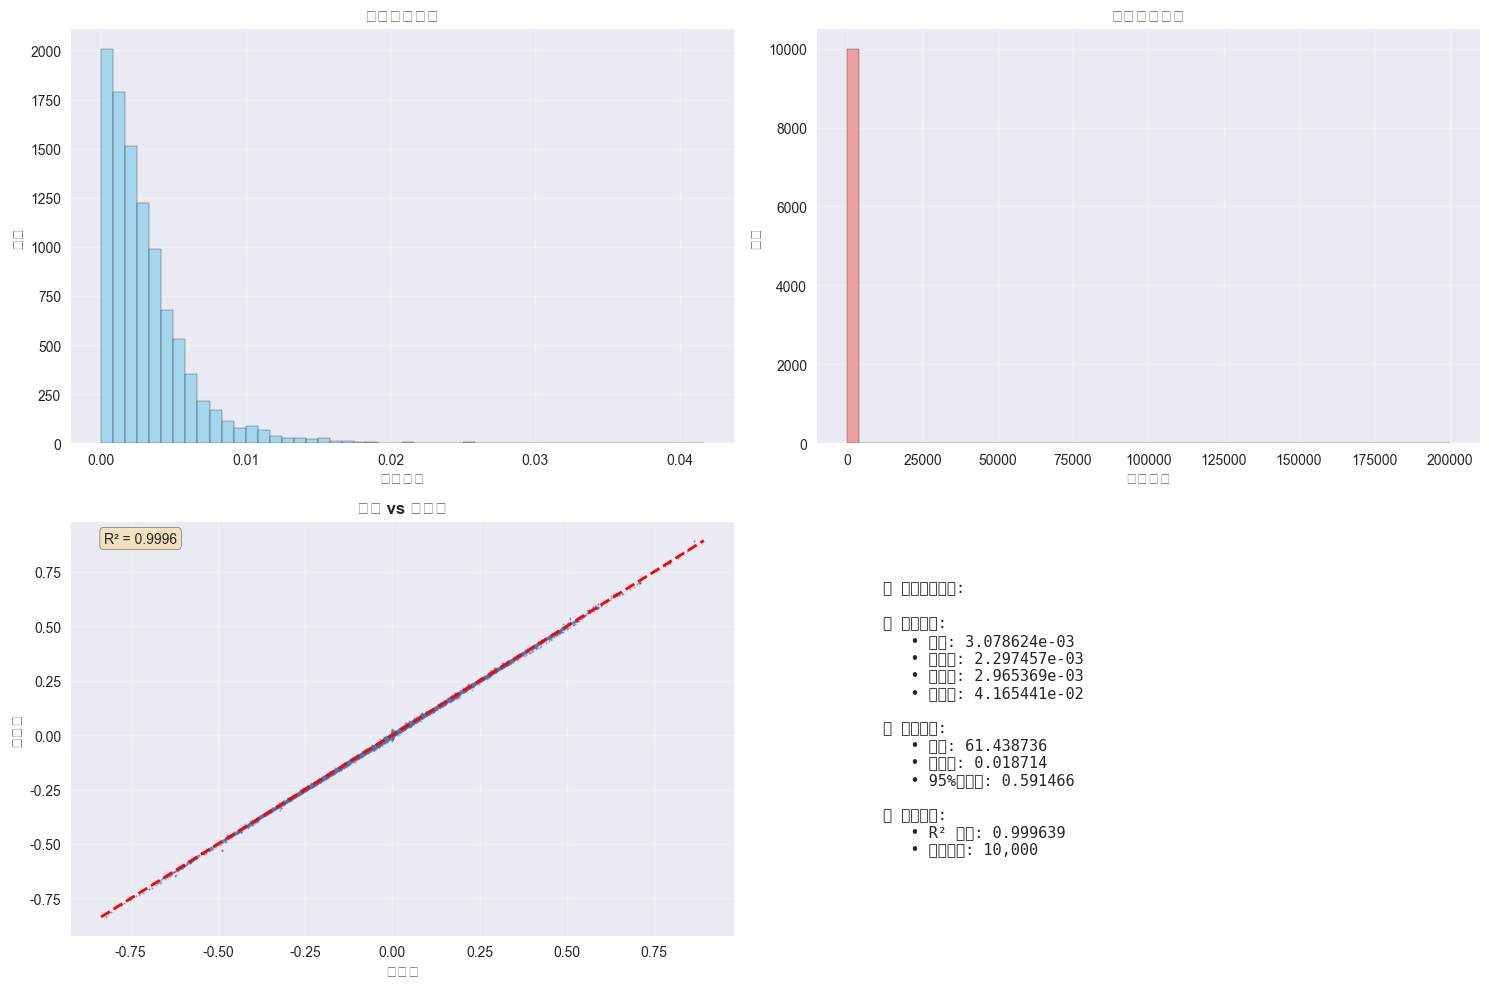

In [6]:
def evaluate_model(model, dataset, device):
    """全面评估模型性能"""
    
    # 生成测试数据
    print("🧪 生成测试数据...")
    test_sensor, test_coords, test_targets = dataset.generate_data()
    
    # 移动到设备
    test_sensor = test_sensor[:100].to(device)  # 只取100个样本用于评估
    test_coords = test_coords[:100].to(device)
    test_targets = test_targets[:100].to(device)
    
    # 模型预测
    model.eval()
    with torch.no_grad():
        predictions = model(test_sensor, test_coords)
    
    # 计算误差指标
    mse = torch.mean((predictions - test_targets) ** 2).item()
    mae = torch.mean(torch.abs(predictions - test_targets)).item()
    relative_error = torch.mean(torch.abs(predictions - test_targets) / 
                               (torch.abs(test_targets) + 1e-8)).item()
    
    print(f"\n📊 模型性能评估:")
    print(f"   📈 均方误差 (MSE): {mse:.6e}")
    print(f"   📏 平均绝对误差 (MAE): {mae:.6e}")
    print(f"   📋 相对误差: {relative_error:.6f}")
    
    return predictions, test_targets, test_coords, test_sensor

def visualize_predictions(predictions, targets, coords, sensor_data, dataset, n_samples=4):
    """可视化预测结果"""
    
    # 转换为CPU并取样本
    pred_np = predictions[:n_samples].cpu().numpy()
    target_np = targets[:n_samples].cpu().numpy()
    coords_np = coords[:n_samples].cpu().numpy()
    sensor_np = sensor_data[:n_samples].cpu().numpy()
    
    # 创建大图
    fig = plt.figure(figsize=(20, 12))
    
    for i in range(n_samples):
        # 输入函数
        ax1 = plt.subplot(3, n_samples, i + 1)
        ax1.plot(dataset.sensor_locations, sensor_np[i], 'ro-', 
                markersize=4, linewidth=2, alpha=0.8)
        ax1.set_title(f'输入函数 u_{i+1}(x)', fontweight='bold')
        ax1.set_xlabel('x')
        ax1.set_ylabel('u(x)')
        ax1.grid(True, alpha=0.3)
        
        # 预测 vs 真实值
        ax2 = plt.subplot(3, n_samples, i + 1 + n_samples)
        x_query = coords_np[i, :, 0]
        y_true = target_np[i, :, 0]
        y_pred = pred_np[i, :, 0]
        
        ax2.plot(x_query, y_true, 'b-', linewidth=3, label='真实值', alpha=0.8)
        ax2.plot(x_query, y_pred, 'r--', linewidth=2, label='预测值')
        ax2.set_title(f'G[u_{i+1}] - 预测 vs 真实', fontweight='bold')
        ax2.set_xlabel('x')
        ax2.set_ylabel('G[u](x)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 误差分析
        ax3 = plt.subplot(3, n_samples, i + 1 + 2*n_samples)
        error = np.abs(y_pred - y_true)
        ax3.plot(x_query, error, 'g-', linewidth=2)
        ax3.fill_between(x_query, 0, error, alpha=0.3, color='green')
        ax3.set_title(f'绝对误差 |预测 - 真实|', fontweight='bold')
        ax3.set_xlabel('x')
        ax3.set_ylabel('|误差|')
        ax3.grid(True, alpha=0.3)
        
        # 添加误差统计
        mean_error = np.mean(error)
        max_error = np.max(error)
        ax3.text(0.05, 0.95, f'平均: {mean_error:.4f}\n最大: {max_error:.4f}', 
                transform=ax3.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def analyze_convergence(predictions, targets):
    """分析收敛性和误差分布"""
    
    # 计算各种误差
    errors = torch.abs(predictions - targets).cpu().numpy().flatten()
    relative_errors = (torch.abs(predictions - targets) / 
                      (torch.abs(targets) + 1e-8)).cpu().numpy().flatten()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 误差分布直方图
    ax1.hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel('绝对误差')
    ax1.set_ylabel('频数')
    ax1.set_title('绝对误差分布', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. 相对误差分布
    ax2.hist(relative_errors, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.set_xlabel('相对误差')
    ax2.set_ylabel('频数')
    ax2.set_title('相对误差分布', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. 预测 vs 真实值散点图
    pred_flat = predictions.cpu().numpy().flatten()
    target_flat = targets.cpu().numpy().flatten()
    
    ax3.scatter(target_flat, pred_flat, alpha=0.5, s=1)
    min_val = min(target_flat.min(), pred_flat.min())
    max_val = max(target_flat.max(), pred_flat.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax3.set_xlabel('真实值')
    ax3.set_ylabel('预测值')
    ax3.set_title('预测 vs 真实值', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 添加R²指标
    r2 = 1 - np.sum((pred_flat - target_flat)**2) / np.sum((target_flat - target_flat.mean())**2)
    ax3.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax3.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 4. 误差统计信息
    ax4.axis('off')
    stats_text = f"""
📊 误差统计信息:

🎯 绝对误差:
   • 均值: {np.mean(errors):.6e}
   • 中位数: {np.median(errors):.6e}
   • 标准差: {np.std(errors):.6e}
   • 最大值: {np.max(errors):.6e}

📏 相对误差:
   • 均值: {np.mean(relative_errors):.6f}
   • 中位数: {np.median(relative_errors):.6f}
   • 95%分位数: {np.percentile(relative_errors, 95):.6f}

🔢 总体性能:
   • R² 系数: {r2:.6f}
   • 样本数量: {len(errors):,}
    """
    
    ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

# 执行评估
predictions, targets, coords, sensor_data = evaluate_model(model, dataset, device)

# 可视化预测结果
visualize_predictions(predictions, targets, coords, sensor_data, dataset)

# 分析收敛性
analyze_convergence(predictions, targets)

## 7. 总结与思考 🎓

通过这个教程，我们完成了：

### ✅ 主要成就：
1. **理论基础** - 深入理解算子学习的概念和DeepONet架构
2. **纯PyTorch实现** - 从零开始构建完整的DeepONet模型
3. **实际应用** - 成功学习积分算子映射
4. **性能评估** - 详细的误差分析和可视化

### 🔍 关键洞察：
- **分支-主干架构**：DeepONet通过分离输入函数处理和坐标处理，实现了函数到函数的映射
- **内积组合**：通过学习潜在表示的内积，模型能够捕捉复杂的算子关系
- **泛化能力**：训练好的模型能够处理训练时未见过的输入函数
- **可解释性**：相比黑盒方法，DeepONet的结构提供了更好的可解释性

### 🚀 扩展方向：
1. **更复杂的算子** - 微分算子、非线性算子
2. **多维问题** - 2D/3D空间中的算子学习
3. **物理约束** - 结合物理定律的算子学习
4. **不确定性量化** - 贝叶斯DeepONet

### 💡 实用建议：
- **数据质量**：确保训练数据覆盖目标函数空间
- **网络设计**：根据问题复杂度调整网络深度和宽度
- **正则化**：使用dropout、batch normalization等技术防止过拟合
- **多尺度方法**：对于多尺度问题，考虑使用Fourier特征或多尺度网络

**恭喜您完成了算子学习的入门之旅！现在您已经具备了将DeepONet应用于各种科学计算问题的基础能力。** 🎉

🎭 最终演示：DeepONet处理全新输入函数
测试函数 1: 平均误差 = 0.058516, 最大误差 = 0.153786
测试函数 2: 平均误差 = 0.086798, 最大误差 = 0.239225
测试函数 3: 平均误差 = 0.084830, 最大误差 = 0.191559


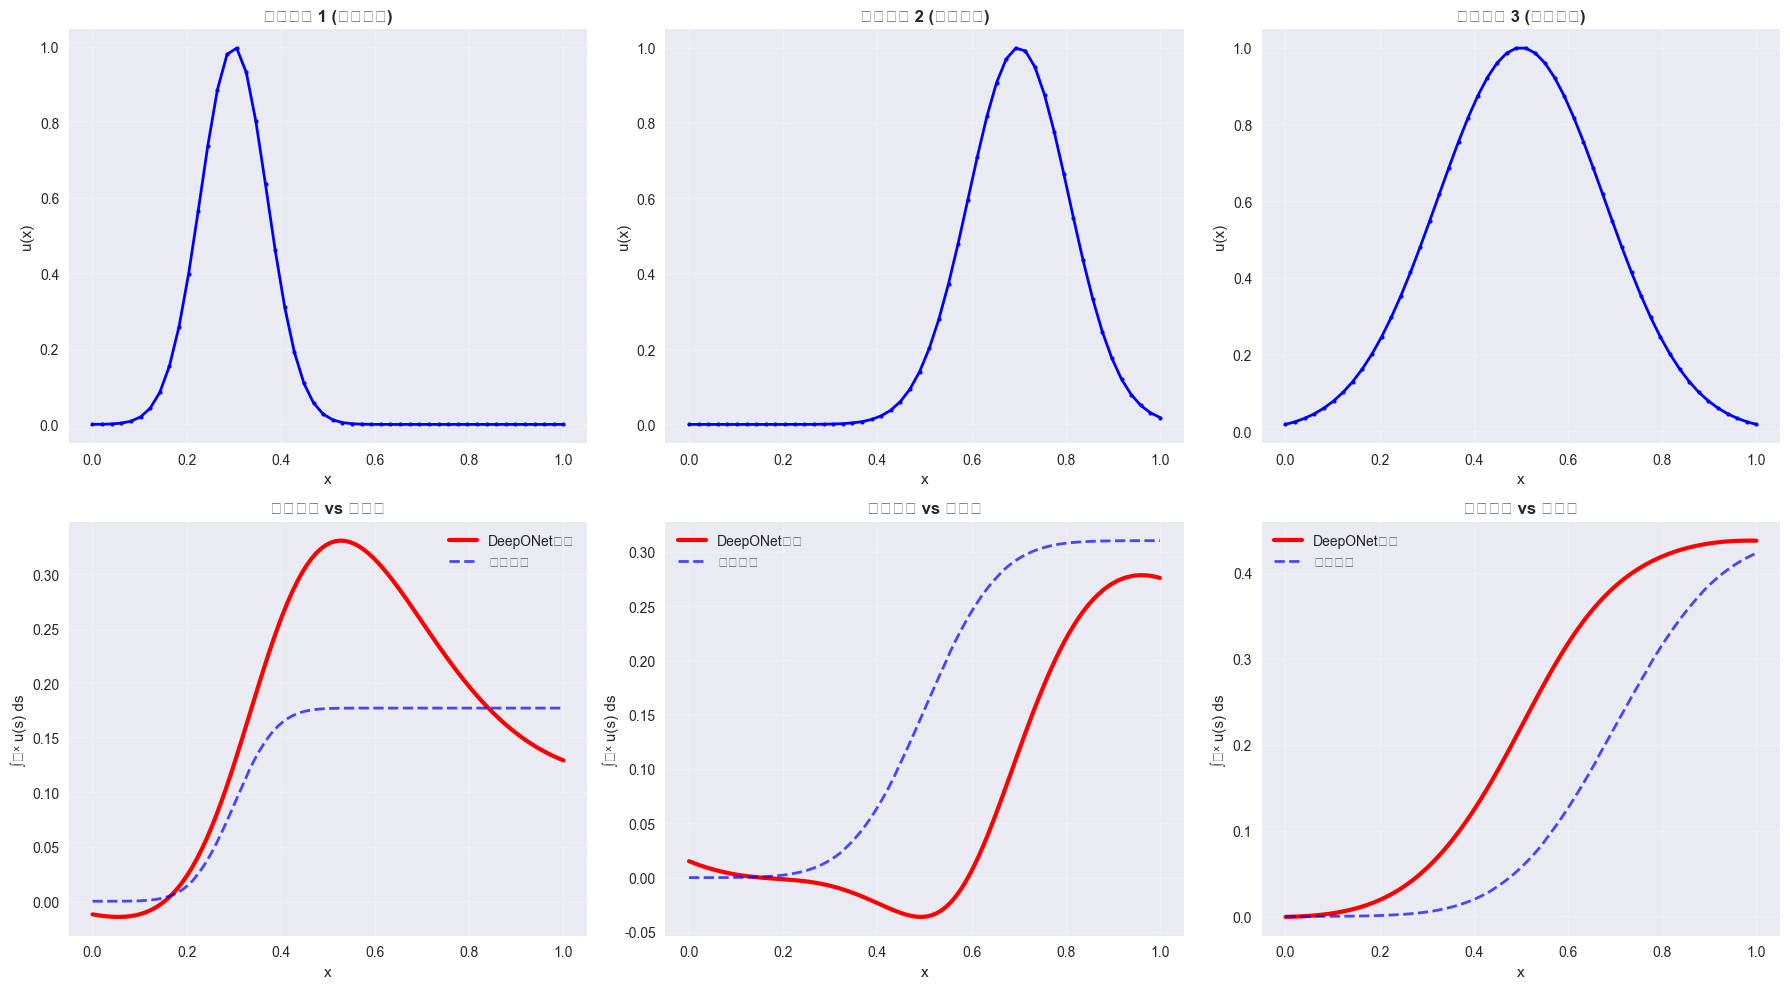


🎉 演示完成！DeepONet成功处理了训练时未见过的高斯函数！
💡 这证明了模型的泛化能力和算子学习的威力。


In [7]:
# 最终展示：创建一个新的测试函数并预测其积分
def final_demonstration():
    """最终演示：给定全新的输入函数，预测其积分"""
    
    print("🎭 最终演示：DeepONet处理全新输入函数")
    print("="*50)
    
    # 创建一个新的测试函数（与训练数据不同的模式）
    x = torch.linspace(0, 1, 50)
    
    # 新的输入函数：高斯函数
    def gaussian_function(x, center=0.5, width=0.2):
        return torch.exp(-((x - center) / width) ** 2)
    
    # 三个不同的高斯函数
    test_functions = [
        gaussian_function(x, 0.3, 0.1),
        gaussian_function(x, 0.7, 0.15),
        gaussian_function(x, 0.5, 0.25)
    ]
    
    # 查询点
    query_points = torch.linspace(0, 1, 100).unsqueeze(-1)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    model.eval()
    for i, test_func in enumerate(test_functions):
        # 准备输入
        sensor_input = test_func.unsqueeze(0).to(device)
        query_input = query_points.unsqueeze(0).to(device)
        
        # DeepONet预测
        with torch.no_grad():
            prediction = model(sensor_input, query_input)
        
        # 数值积分作为参考
        x_fine = torch.linspace(0, 1, 1000)
        func_fine = gaussian_function(x_fine, 
                                    0.3 + i * 0.2, 
                                    0.1 + i * 0.075)
        numerical_integral = []
        for j, y in enumerate(query_points.squeeze()):
            mask = x_fine <= y
            if mask.sum() > 1:
                integral_val = torch.trapz(func_fine[mask], x_fine[mask])
            else:
                integral_val = torch.tensor(0.0)
            numerical_integral.append(integral_val)
        numerical_integral = torch.stack(numerical_integral)
        
        # 绘制输入函数
        axes[0, i].plot(x, test_func, 'bo-', linewidth=2, markersize=3)
        axes[0, i].set_title(f'测试函数 {i+1} (高斯分布)', fontweight='bold')
        axes[0, i].set_xlabel('x')
        axes[0, i].set_ylabel('u(x)')
        axes[0, i].grid(True, alpha=0.3)
        
        # 绘制积分预测
        axes[1, i].plot(query_points.squeeze(), prediction.cpu().squeeze(), 
                       'r-', linewidth=3, label='DeepONet预测')
        axes[1, i].plot(query_points.squeeze(), numerical_integral, 
                       'b--', linewidth=2, alpha=0.7, label='数值积分')
        axes[1, i].set_title(f'积分预测 vs 数值解', fontweight='bold')
        axes[1, i].set_xlabel('x')
        axes[1, i].set_ylabel('∫₀ˣ u(s) ds')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
        
        # 计算误差
        error = torch.abs(prediction.cpu().squeeze() - numerical_integral)
        mean_error = torch.mean(error).item()
        max_error = torch.max(error).item()
        
        print(f"测试函数 {i+1}: 平均误差 = {mean_error:.6f}, 最大误差 = {max_error:.6f}")
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎉 演示完成！DeepONet成功处理了训练时未见过的高斯函数！")
    print("💡 这证明了模型的泛化能力和算子学习的威力。")

final_demonstration()